# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric points](https://review.udacity.com/#!/rubrics/513/view)

## Data Exploration

In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

Disable notebook autoscrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
with open('training_data/dataset.p', mode='rb') as f:
    data = pickle.load(f)
    images, labels = data['images'], data['labels']
    
n_cars = len(labels[labels==1])
n_notcars = len(labels[labels==0])

print('Data set consists of {} cars and {} non-cars of size: {} and data type: {}.'.
      format(n_cars, n_notcars, images[0].shape, images[0].dtype))

Data set consists of 8792 cars and 8968 non-cars of size: (64, 64, 3) and data type: uint8.


## Color Histograms and Spatial Binning of Color

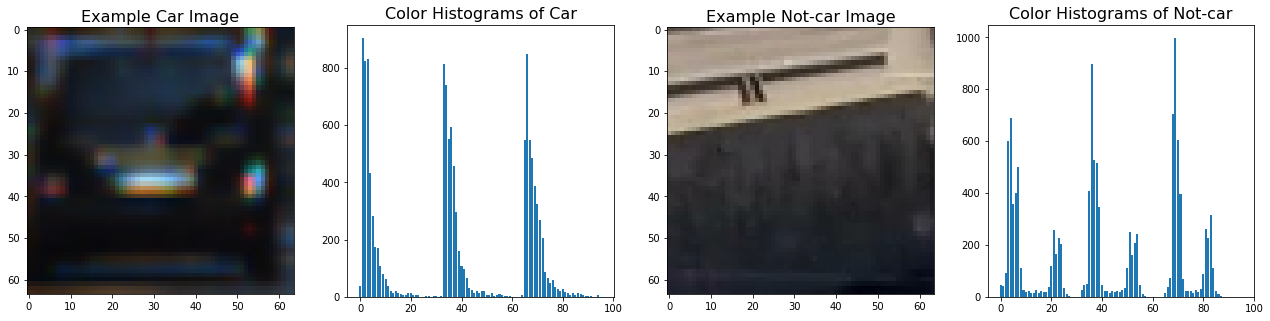

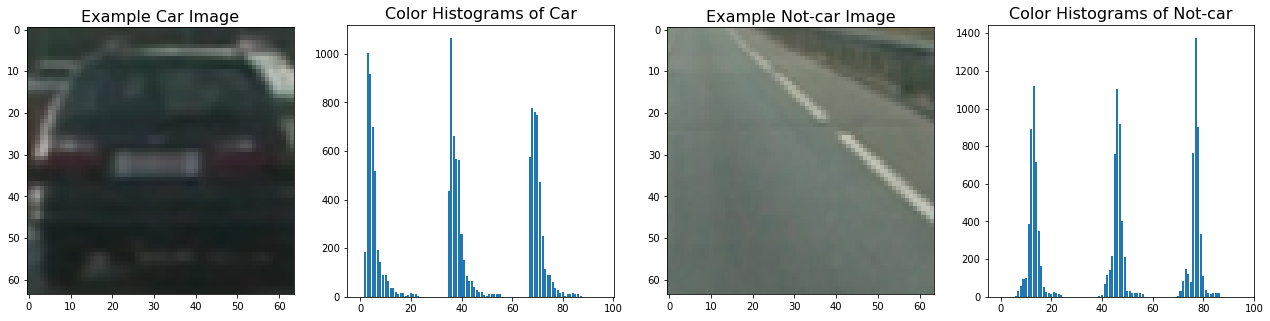

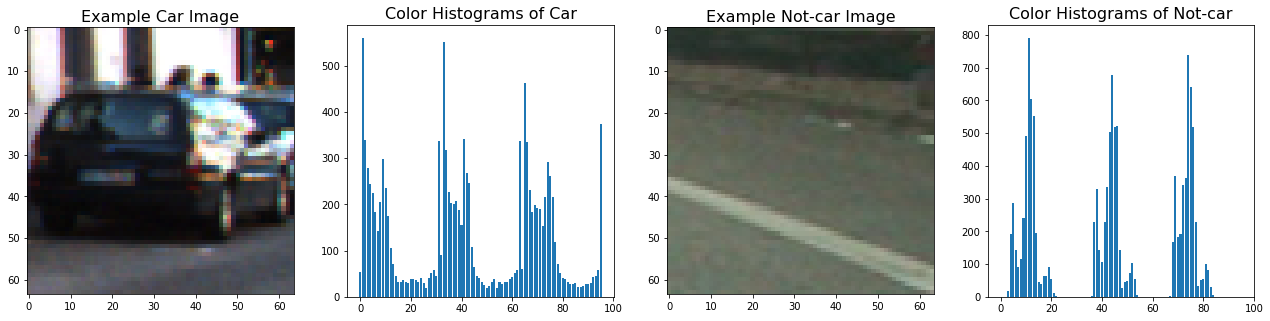

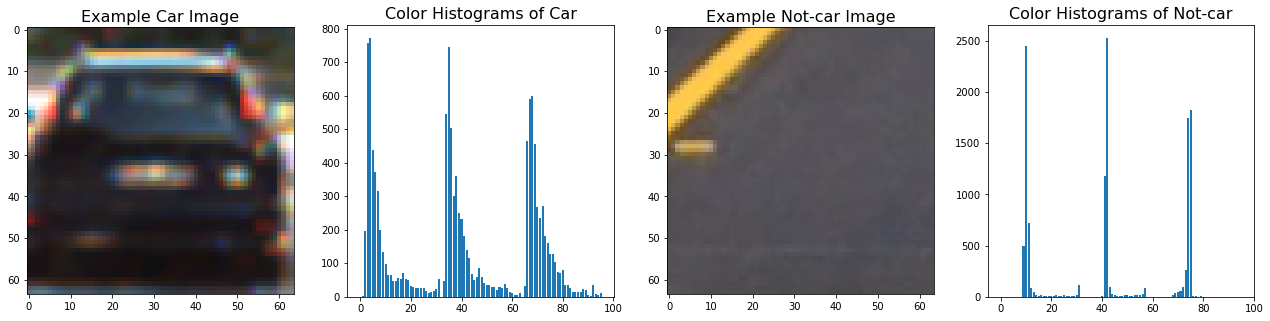

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    '''
    Compute color histogram features
    '''
    # Compute the histogram of each channel separately
    hist0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist0[0], hist1[0], hist2[0]))
    # Return feature vector
    return hist_features


for i in range(4):
    # Generate random indices
    car_ind = np.random.randint(0, n_cars)
    notcar_ind = np.random.randint(0, n_notcars)
    # Read in car / not-car images
    car_image = images[car_ind]
    notcar_image = images[n_cars+notcar_ind]
    # Get color histogram features
    car_features = color_hist(car_image, nbins=32)
    notcar_features = color_hist(notcar_image, nbins=32)

    # Plot features
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    ax1.imshow(car_image)
    ax1.set_title('Example Car Image', fontsize=16)
    ax2.bar(np.arange(len(car_features)), car_features)
    ax2.set_title('Color Histograms of Car', fontsize=16)

    ax3.imshow(notcar_image)
    ax3.set_title('Example Not-car Image', fontsize=16)
    ax4.bar(np.arange(len(notcar_features)), notcar_features)
    ax4.set_title('Color Histograms of Not-car', fontsize=16)

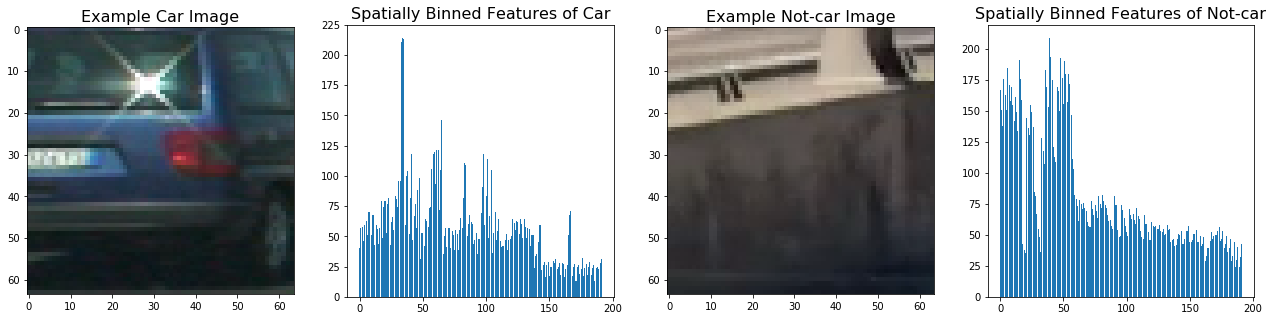

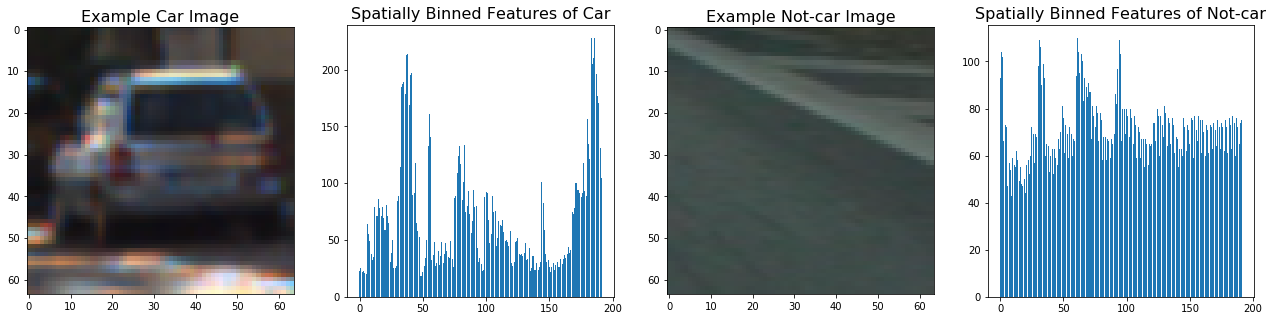

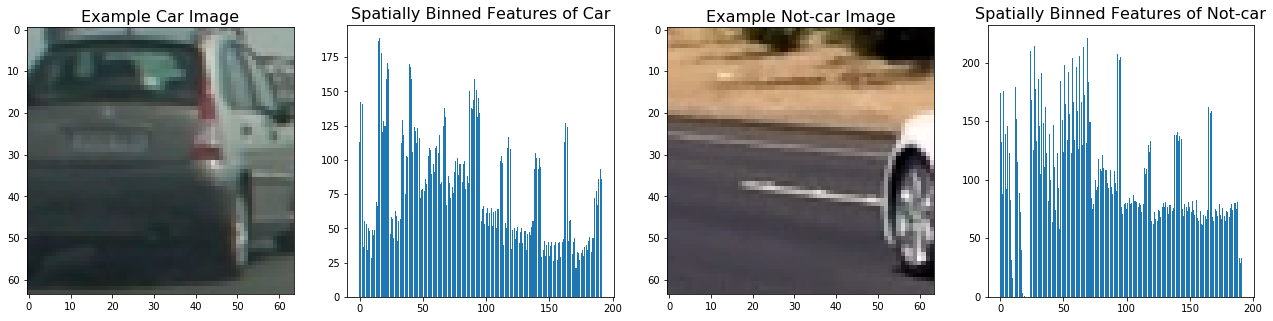

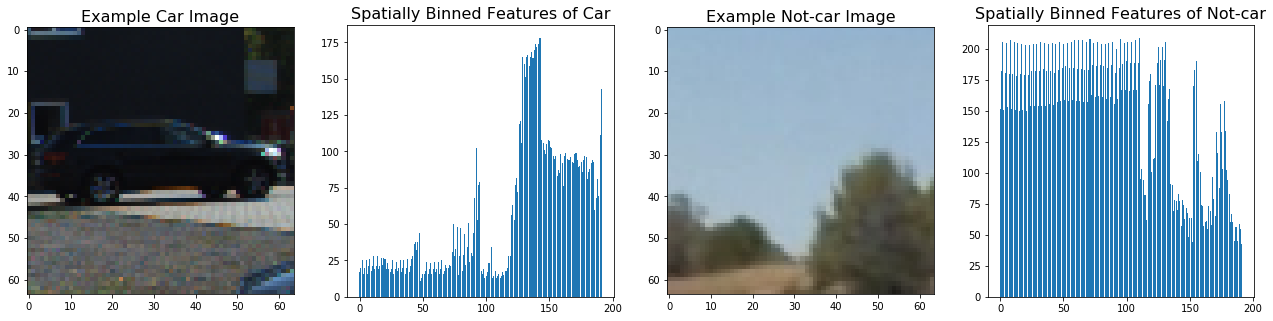

In [5]:
def bin_spatial(img, size=(32, 32)):
    '''
    Compute spatial color binning
    '''
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

for i in range(4):
    # Generate random indices
    car_ind = np.random.randint(0, n_cars)
    notcar_ind = np.random.randint(0, n_notcars)
    # Read in car / not-car images
    car_image = images[car_ind]
    notcar_image = images[n_cars+notcar_ind]
    # Get spatial binned features
    car_features = bin_spatial(car_image, size=(8, 8))
    notcar_features = bin_spatial(notcar_image, size=(8, 8))

    # Plot features
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    ax1.imshow(car_image)
    ax1.set_title('Example Car Image', fontsize=16)
    ax2.bar(np.arange(len(car_features)), car_features)
    ax2.set_title('Spatially Binned Features of Car', fontsize=16)

    ax3.imshow(notcar_image)
    ax3.set_title('Example Not-car Image', fontsize=16)
    ax4.bar(np.arange(len(notcar_features)), notcar_features)
    ax4.set_title('Spatially Binned Features of Not-car', fontsize=16)

## Histogram of Oriented Gradients

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Get HOG features and visualization for a grayscaled image
    '''
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations = orient, 
                                  pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block = (cell_per_block, cell_per_block),
                                  visualise=True, feature_vector=feature_vec,
                                  transform_sqrt=True, block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations = orient, 
                       pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block = (cell_per_block, cell_per_block),
                       visualise=False, feature_vector=feature_vec,
                       transform_sqrt=True, block_norm="L2-Hys")
        return features

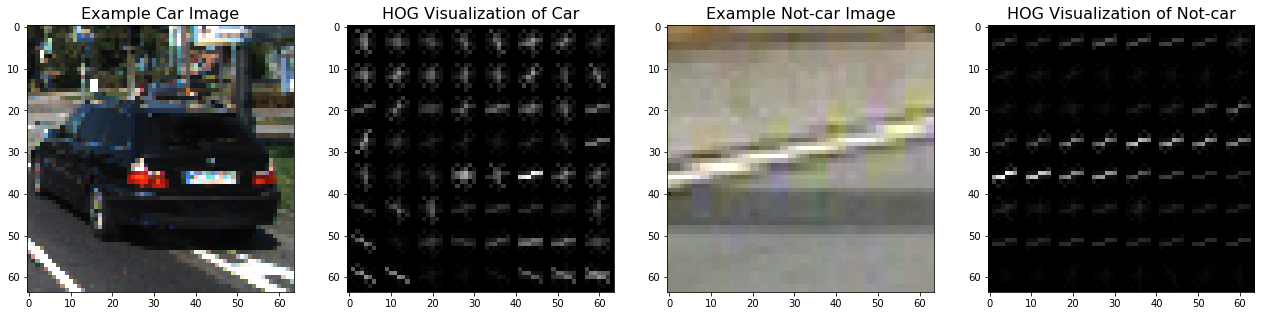

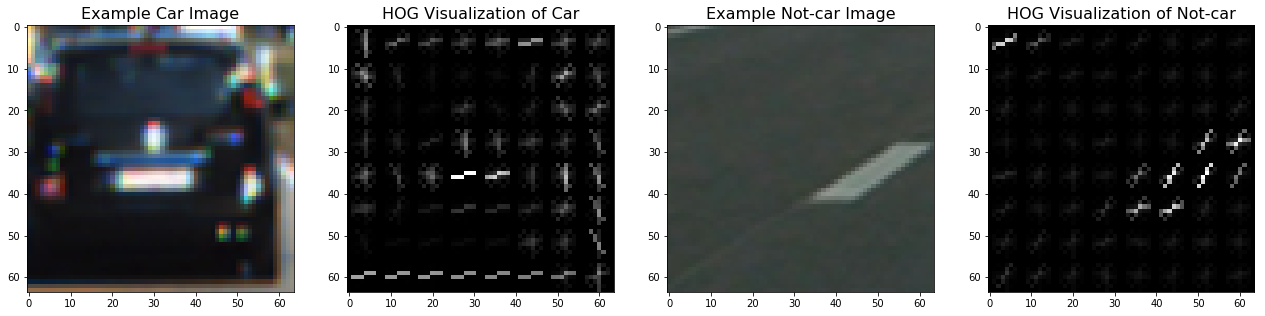

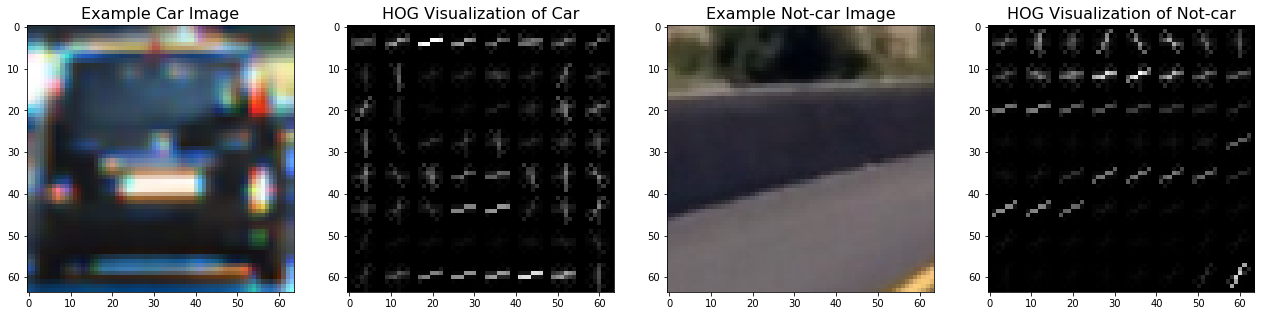

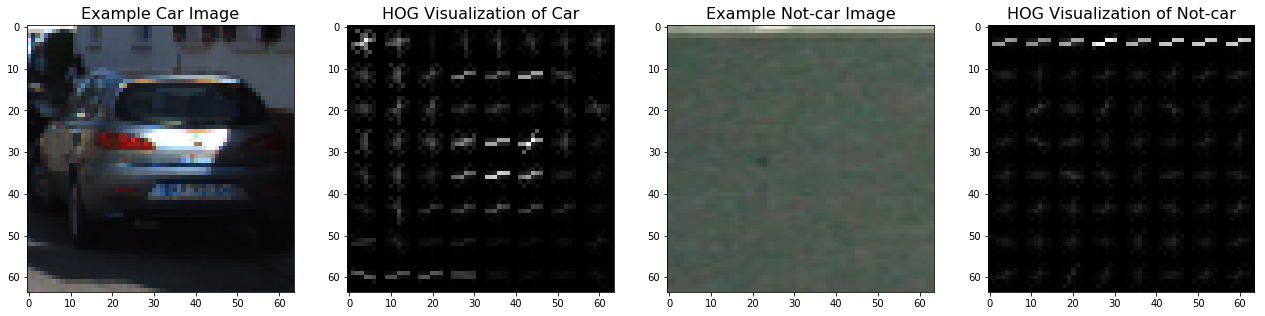

In [7]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2


for i in range(4):
    # Generate random indices
    car_ind = np.random.randint(0, n_cars)
    notcar_ind = np.random.randint(0, n_notcars)
    # Read in car / not-car images
    car_image = images[car_ind]
    notcar_image = images[n_cars+notcar_ind]
    # Call our function with vis=True to see an image output
    car_features, car_hog_image = get_hog_features(car_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                                                   vis=True, feature_vec=False)
    notcar_features, notcar_hog_image = get_hog_features(notcar_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                                                         vis=True, feature_vec=False)

    # Plot features
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    ax1.imshow(car_image)
    ax1.set_title('Example Car Image', fontsize=16)
    ax2.imshow(car_hog_image, cmap='gray')
    ax2.set_title('HOG Visualization of Car', fontsize=16)

    ax3.imshow(notcar_image)
    ax3.set_title('Example Not-car Image', fontsize=16)
    ax4.imshow(notcar_hog_image, cmap='gray')
    ax4.set_title('HOG Visualization of Not-car', fontsize=16)

## SVC Training

In [8]:
def extract_features(img, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, 
                     spatial_size=(32, 32), hist_bins=32):
    '''
    Get HOG and color features for an RGB image
    '''
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        RGB2cspace = getattr(cv2, 'COLOR_RGB2{}'.format(cspace))
        img = cv2.cvtColor(img, RGB2cspace) 

    # HOG feature extraction
    hog_features = []
    for channel in range(img.shape[2]):
        hog_features.append(get_hog_features(img[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features) 
    
    # get spatial color features
    feature_bin = bin_spatial(img, size=spatial_size)
    # get color histogram features
    feature_hist = color_hist(img, nbins=hist_bins)
    
    # combine HOG and color features
    features = np.concatenate((hog_features, feature_bin, feature_hist))
    return features

In [9]:
# Set parameters for feature extraction
cspace = 'YCrCb'
hog_orient = 9
hog_ppc = 16
hog_cpb = 2
col_size = (8, 8)
col_bins = 64

# Create a list to append feature vectors to
features = []
# Iterate through the list of images
t=time.time()
for img in images:
    features.append(extract_features(img, cspace=cspace, orient=hog_orient, pix_per_cell=hog_ppc, 
                                     cell_per_block=hog_cpb, spatial_size=col_size, hist_bins=col_bins))
t2 = time.time()
print('%.2f seconds to extract %i features in %i samples'%(t2-t, len(features[0]), len(features)))

# Create an array stack of feature vectors
X = np.vstack((features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels, test_size=0.2, 
                                                    stratify=labels, random_state=rand_state)

# Use a linear SVC (support vector classifier)
clf = LinearSVC(C=0.1) 
# Check the training time for the SVC
t=time.time()
# Train the SVC
clf.fit(X_train, y_train)
t2 = time.time()
print('%.2f seconds to train SVC, test accuracy = %.4f'%(t2-t, clf.score(X_test, y_test)))


# Re-train the SVC on the entire dataset for better accuracy
clf.fit(scaled_X, labels)
print('re-train accuracy = %.4f'%(clf.score(scaled_X, labels)))

# save the trained model
svc_pickel = {}
svc_pickel["clf"] = clf
svc_pickel["X_scaler"] = X_scaler
pickle.dump( svc_pickel, open( "training_data/svc_pickel_v5.p", "wb" ) )

# # load the trained model
# with open('training_data/svc_pickel_v5.p', mode='rb') as f:
#     data = pickle.load(f)
#     clf, X_scaler = data['clf'], data['X_scaler']

71.77 seconds to extract 1356 features in 17760 samples
3.00 seconds to train SVC, test accuracy = 0.9904
re-train accuracy = 1.0000


## Hog Sub-sampling Window Search

In [10]:
def find_cars(img, multi_scale_pars, clf, X_scaler, thresh_score=1,
              cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, 
              spatial_size=(32, 32), hist_bins=32):
    '''
    Vehicle detection pipeline using HOG sub-sampling
    '''    
    draw_img = np.copy(img)
    # initialize a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float32)
    
    for pars in multi_scale_pars:
        
        ystart, ystop, scale = pars[0], pars[1], pars[2]
        
        img_tosearch = img[ystart:ystop,:,:]  
        RGB2cspace = getattr(cv2, 'COLOR_RGB2{}'.format(cspace))
        ctrans_tosearch = cv2.cvtColor(img_tosearch, RGB2cspace) 
    
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 1  # Instead of overlap, define how many cells to step       
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
                # Predict the confidence scores of the sample
                test_score = clf.decision_function(test_features)

                # Vechicle detection with high-confidence
                if test_score > thresh_score:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart))
                    cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6) 
                    # Add heat to each box in box list
                    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += min(1, test_score)

    return draw_img, heatmap

In [11]:
def apply_threshold(heatmap, threshold):
    '''
    Threshold the heatmap
    '''
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 5)
        cv2.putText(img, '%i'%(car_number), (bbox[1][0]+10,bbox[1][1]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    # Return the image
    return img

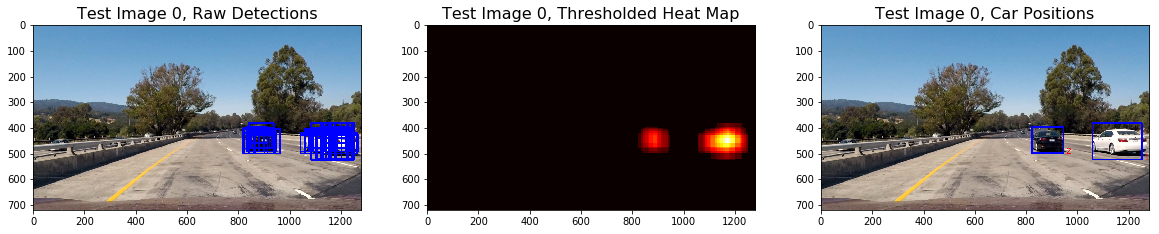

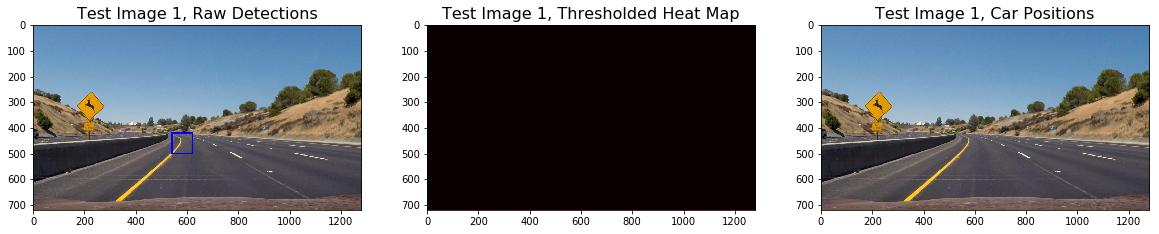

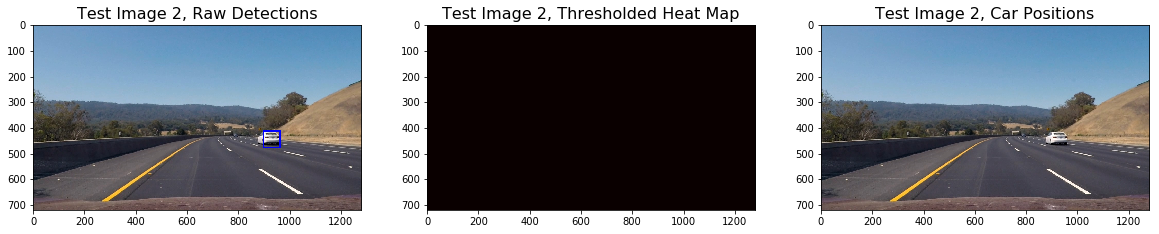

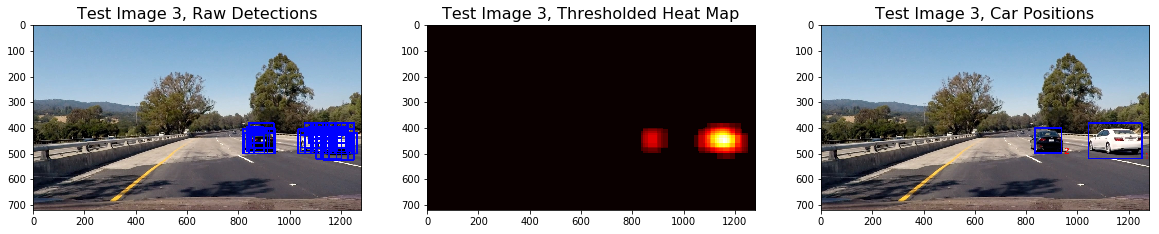

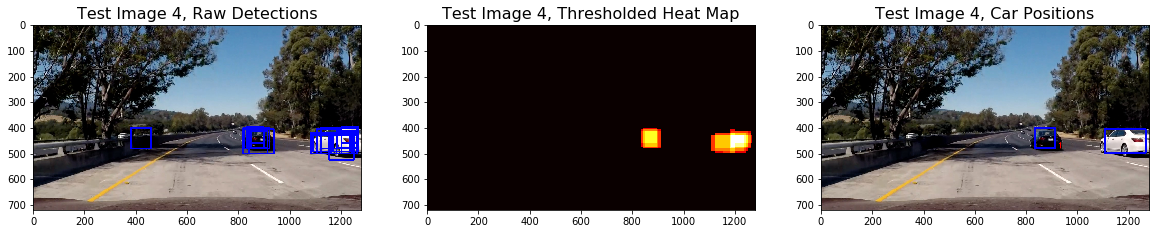

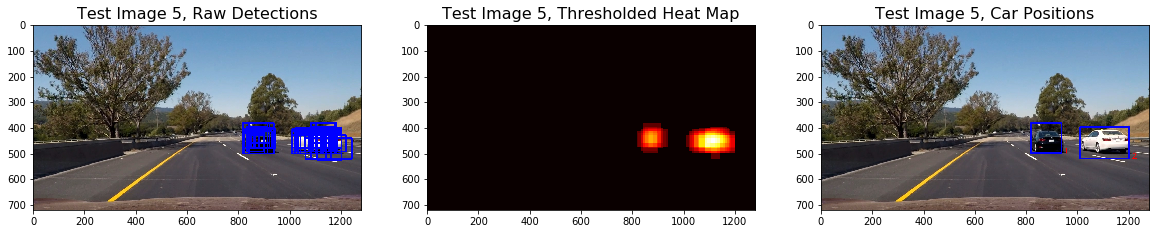

In [12]:
# Set parameters for multi-scale search windowns
multi_scale_settings = [(380, 508, 1),     # ystart, ystop, scale
                        (380, 572, 1.25),
                        (380, 668, 1.5)]
threshold_score = 1.0
threshold_heat = 2

# Make a list of test images
test_images = glob.glob('test_images/test*.jpg')

# Visualize search and classify using HOG sub-sampling
for i, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    
    out_img, heatmap = find_cars(img, multi_scale_settings, clf=clf, X_scaler=X_scaler, thresh_score=threshold_score,
                                 cspace=cspace, orient=hog_orient, pix_per_cell=hog_ppc, 
                                 cell_per_block=hog_cpb, spatial_size=col_size, hist_bins=col_bins)  
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshold_heat)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(out_img)
    ax1.set_title('Test Image {}, Raw Detections'.format(i), fontsize=16)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Test Image {}, Thresholded Heat Map'.format(i), fontsize=16) 
    ax3.imshow(draw_img)
    ax3.set_title('Test Image {}, Car Positions'.format(i), fontsize=16)

## Vehicle Class

In [13]:
class Vehicle():
    """
    Define a class to record the heatmaps of vehicle detections
    """
    def __init__(self):
        # number of frames to sum over
        self.n_iter = 15  
        # heatmaps of the last n iterations
        self.recent_heatmap = []     
        # heatmap averaged over the last n iterations
        self.sum_heatmap = None 

    def add_heat(self, heatmap):
        '''
        Accumulate the heatmap
        '''
        # Insert the new heatmap to the front of the list
        self.recent_heatmap.insert(0, heatmap)
        # If the list has more than n elements, remove the last one
        if len(self.recent_heatmap) > self.n_iter:
            self.recent_heatmap.pop()
        
        # Update the accumulated heatmap over the last n iterations
        self.sum_heatmap = np.sum(self.recent_heatmap, axis=0)
    
        return self.sum_heatmap

## Process pipeline

In [14]:
threshold_heat = 50

def process_image(image, diagnosis=True):
    '''
    Apply process pipeline on test images
    
    NOTE: The output is a color image (3 channel) for processing video below
    '''
    
    out_img, heatmap = find_cars(image, multi_scale_settings, clf=clf, X_scaler=X_scaler, thresh_score=threshold_score,
                                 cspace=cspace, orient=hog_orient, pix_per_cell=hog_ppc, 
                                 cell_per_block=hog_cpb, spatial_size=col_size, hist_bins=col_bins)     
    
    heatmap = veh.add_heat(heatmap)
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshold_heat)
    heatmap = np.clip(heatmap, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(image), labels)
    
    if diagnosis==True:
        # Create an image to draw the result and diagnosis images
        diag_w = result.shape[1]//2
        diag_h = result.shape[0]//2
        screen = np.ones((result.shape[0], result.shape[1]+diag_w, 3), dtype=np.uint8)*255   
        
        # Draw result image to screen
        screen[0:result.shape[0], 0:result.shape[1]] = result
        
        # Draw diagnosis images to screen
        img_d1 = np.dstack((heatmap, np.zeros_like(heatmap), np.zeros_like(heatmap)))
        screen[0:diag_h-2, result.shape[1]+4:] = cv2.resize(img_d1, (diag_w-4, diag_h-2))
        screen[diag_h+2:, result.shape[1]+4:] = cv2.resize(out_img, (diag_w-4, diag_h-2))        

        return screen
    else:
        return result

## Video Implementation

In [15]:
veh = Vehicle()

test_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|██████████████████████████████████████████████▉| 1260/1261 [26:30<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 26min 32s


In [16]:
HTML("""
<video width="760" height="300" controls>
  <source src="{0}">
</video>
""".format(test_output))